Time taken: 2.11 s


Dropdown(description='Color', index=122, options=('Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', …

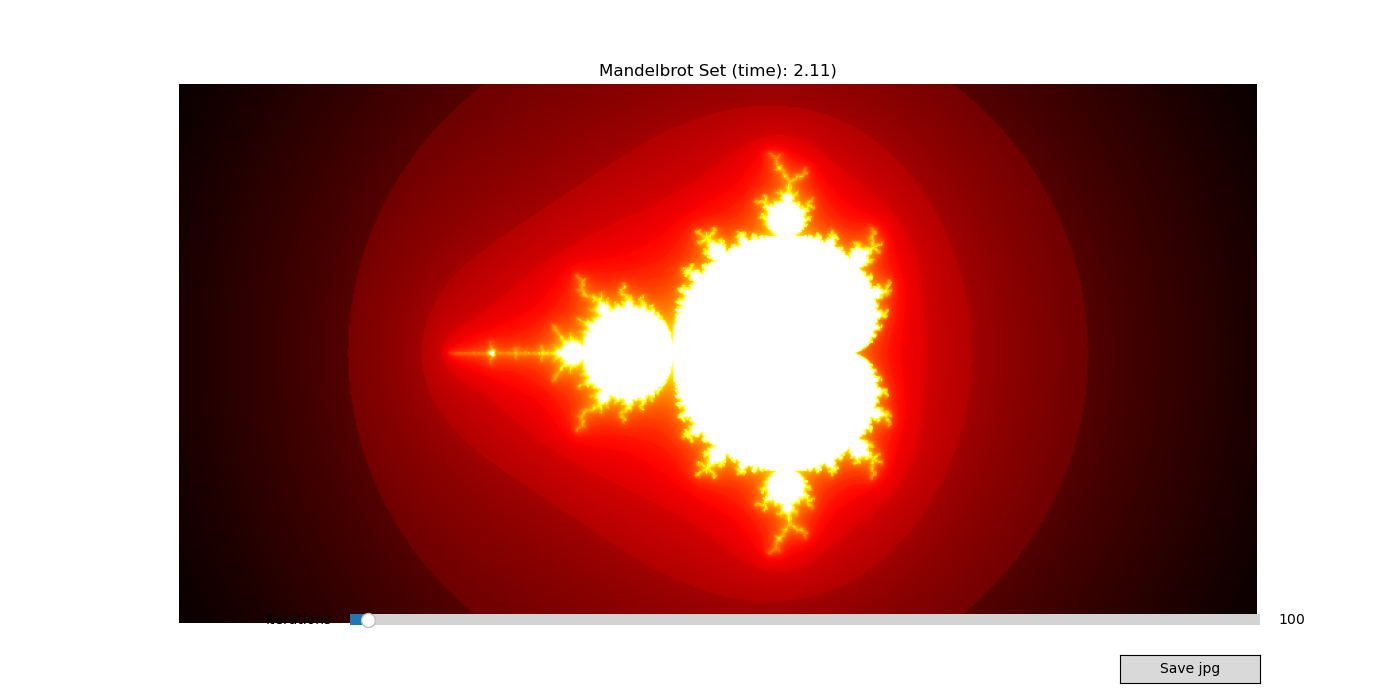

In [2]:
%matplotlib widget
import numba as nb
import time
from matplotlib.widgets import Slider
from scipy.ndimage import median_filter
from matplotlib.widgets import Button
import ipywidgets as widgets
import torch

"""
Replace the largest and smallest elements in a 2D array with the second largest element in their 3x3 neighborhood.
Parameters:
arr (numpy.ndarray): A 2D numpy array of numerical values.
Returns:
numpy.ndarray: A new 2D numpy array with the largest and smallest elements replaced by the second largest element in their 3x3 neighborhood.
Notes:
- The function uses Numba's JIT compilation for parallel execution and fast math optimizations.
- The function processes the array elements excluding the border elements.
"""
@nb.njit(parallel=True, fastmath=True)
def replace_largest_with_second_largest(arr):
    new_arr = arr.copy()
    for i in nb.prange(1, arr.shape[0] - 1):
        for j in nb.prange(1, arr.shape[1] - 1):
            sorted_array = sorted(arr[i-1:i+1, j-1:j+1].flatten())
            max_val = sorted_array[-1]
            min_val = sorted_array[0]
            middle_val = sorted_array[-4]
            if  arr[i, j] == max_val:
                new_arr[i,j] = sorted_array[-2]
            if arr[i, j] == min_val:
                new_arr[i, j] = sorted_array[1]
    return new_arr
    
import numpy as np

import matplotlib.pyplot as plt

# Initial parameters
x_min, x_max = -3.5, 2.5
y_min, y_max = -1.5, 1.5
max_iter = 100
# Button for high resolution PDF

def save_pdf(event):
    """
    Generates a high-resolution image of the Mandelbrot set and saves it as a JPEG file.

    Parameters:
    event (matplotlib.backend_bases.Event): The event that triggers the function.

    This function performs the following steps:
    1. Generates the Mandelbrot set using the specified parameters.
    2. Replaces the largest values in the set with the second largest values.
    3. Converts the Mandelbrot set data to an RGB image using the current color palette.
    4. Saves the RGB image as a high-resolution JPEG file named 'mandelbrot_high_res.jpg'.
    5. Prints a confirmation message indicating the file has been saved.
    """
    global current_palette
    Z = create_mandelbrot(x_min, x_max, y_min, y_max, 4000, 2000, max_iter)
    Z = replace_largest_with_second_largest(Z)
    Z_rgb = plt.get_cmap(current_palette)(np.log(Z.T/Z.min())/np.log(max_iter/Z.min()))
    Z_rgb = (Z_rgb[:, :, :3] * 255).astype(np.uint8)
    plt.imsave('mandelbrot_high_res.pdf', Z_rgb, origin='lower', format='pdf')
    print("High resolution pdf saved as 'mandelbrot_high_res.pdf'")


@nb.njit(fastmath=True)
# Function to compute the Mandelbrot set
def mandelbrot(c, max_iter):
    """
    Compute the number of iterations for a complex number to escape the Mandelbrot set.
    Parameters:
    c (complex): The complex number to test.
    max_iter (int): The maximum number of iterations to perform.
    Returns:
    int or float: The number of iterations it took for the complex number to escape the Mandelbrot set.
                  If the number does not escape within the maximum number of iterations, returns max_iter.
    """
    
    z = c
    for n in range(max_iter):
        if z.imag*z.imag + z.real*z.real > 16:
            return n - np.log(np.log2(np.abs(z)))
        z = z*z + c
    
    return max_iter  

# Function to create the Mandelbrot image
@nb.njit(fastmath=True, parallel=True)
def create_mandelbrot(x_min, x_max, y_min, y_max, width, height, max_iter):
    """
    Generates a Mandelbrot set image.

    Parameters:
    x_min (float): Minimum x-coordinate (real part) of the complex plane.
    x_max (float): Maximum x-coordinate (real part) of the complex plane.
    y_min (float): Minimum y-coordinate (imaginary part) of the complex plane.
    y_max (float): Maximum y-coordinate (imaginary part) of the complex plane.
    width (int): Width of the output image in pixels.
    height (int): Height of the output image in pixels.
    max_iter (int): Maximum number of iterations to determine if a point is in the Mandelbrot set.

    Returns:
    numpy.ndarray: A 2D array representing the Mandelbrot set, where each element corresponds to the number of iterations for the respective point in the complex plane.
    """
    r1 = np.linspace(np.float64(x_min), np.float64(x_max), width)
    r2 = np.linspace(np.float64(y_min), np.float64(y_max), height)
    n3 = np.empty((width, height))
    for i in nb.prange(width):
        for j in nb.prange(height):
            n3[i, j] = mandelbrot(r1[i] + 1j*r2[j], max_iter)
    return n3

def create_mandelbrot_torch(x_min, x_max, y_min, y_max, width, height, max_iter):
    """
    Generates the Mandelbrot set using PyTorch.
    Args:
        x_min (float): Minimum x-coordinate (real part) of the complex plane.
        x_max (float): Maximum x-coordinate (real part) of the complex plane.
        y_min (float): Minimum y-coordinate (imaginary part) of the complex plane.
        y_max (float): Maximum y-coordinate (imaginary part) of the complex plane.
        width (int): Number of points along the x-axis.
        height (int): Number of points along the y-axis.
        max_iter (int): Maximum number of iterations to determine divergence.
    Returns:
        numpy.ndarray: A 2D array where each element represents the iteration count at which the corresponding point diverged.
    """

    device = torch.device('cpu' if torch.backends.mps.is_available() else 'cpu')
    r1 = torch.linspace(x_min, x_max, width, dtype=torch.float64, device=device)
    r2 = torch.linspace(y_min, y_max, height, dtype=torch.float64, device=device)
    c = r1.unsqueeze(1) + 1j * r2.unsqueeze(0)
    z = torch.zeros_like(c)
    div_time = torch.zeros(c.shape, dtype=torch.int32, device=device)
    
    for i in range(max_iter):
        z = z * z + c
        mask = (div_time == 0) & (z.abs() > 2)
        div_time[mask] = i
    
    div_time[div_time == 0] = max_iter
    return div_time.cpu().numpy()

# Function to update the plot
current_palette = 'hot'
def update_plot(ax, x_min, x_max, y_min, y_max, max_iter):
    global current_palette
    ax.clear()
    start_time = time.time()
    Z = create_mandelbrot(x_min, x_max, y_min, y_max, 800, 400, max_iter)
    Z=replace_largest_with_second_largest(Z)
#    Z_rgb = plt.cm.hot (np.log(Z.T+1-Z.min())/np.log(Z.max()-Z.min()))
#    Z_rgb = (Z_rgb[:, :, :3] * 255).astype(np.uint8)
#    plt.imsave('mandelbrot1.pdf', Z_rgb, origin='lower')
#    plt.imsave('mandelbrot1.jpg', Z_rgb, origin='lower', format="jpg")
    ax.imshow(np.log(Z.T+1), extent=[x_min, x_max, y_min, y_max], origin='lower', cmap=current_palette)
    ax.axis('off')
    ax.set_title(f'Mandelbrot Set (time): {time.time() - start_time:.2f})')
    plt.draw()
    
    # plt.savefig('mandelbrot.pdf', format='pdf', bbox_inches='tight',dpi=300)
    print(f"Time taken: {time.time() - start_time:.2f} s")

# Initial plot
fig, ax = plt.subplots()
plt.title('Mandelbrot Set')
fig.canvas.manager.set_window_title('Visualization')
fig.set_size_inches(14, 7)
fig.set_dpi(72)
update_plot(ax, x_min, x_max, y_min, y_max, max_iter)

# Slider for iterations
ax_iter = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_iter = Slider(ax_iter, 'Iterations', 1, 5000, valinit=max_iter, valstep=1)

# Update function for slider
def update(val):
    global max_iter
    max_iter = int(slider_iter.val)
    update_plot(ax, x_min, x_max, y_min, y_max, max_iter)

slider_iter.on_changed(update)

# Zoom function
def on_click(event):
    """
    Event handler for mouse click events to zoom in and out of a plot.
    Parameters:
    event (matplotlib.backend_bases.MouseEvent): The mouse event that triggered the handler.
    Behavior:
    - If the left mouse button is clicked, the plot zooms in centered on the click location.
    - If the right mouse button is clicked, the plot zooms out centered on the click location.
    - The zoom factor is 1/3 for zooming in and 3 for zooming out.
    Note:
    - The function updates the global variables x_min, x_max, y_min, and y_max to reflect the new plot boundaries.
    - The function calls update_plot to refresh the plot with the new boundaries.
    """
    
    global x_min, x_max, y_min, y_max
    if event.inaxes is not ax:
        return
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_center = event.xdata
    y_center = event.ydata
    if event.button == 1:  # Left click to zoom in
        x_min, x_max = x_center - x_range / 6, x_center + x_range / 6
        y_min, y_max = y_center - y_range / 6, y_center + y_range / 6
    elif event.button == 3:  # Right click to zoom out
        x_min, x_max = x_center - 1.5*x_range, x_center + 1.5*x_range
        y_min, y_max = y_center - 1.5*y_range, y_center + 1.5*y_range
    update_plot(ax, x_min, x_max, y_min, y_max, max_iter)

fig.canvas.mpl_connect('button_press_event', on_click)

ax_button = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(ax_button, 'Save jpg')
button.on_clicked(save_pdf)
# Dropdown menu for color palettes

# List of color palettes
color_palettes = sorted(plt.colormaps())

# Initial color palette
current_palette = 'hot'

# Function to update the color palette
def update_palette(label):
    global current_palette
    current_palette = label
    update_plot(ax, x_min, x_max, y_min, y_max, max_iter)

# Create the dropdown menu
dropdown = widgets.Dropdown(
    options=color_palettes,
    value=current_palette,
    description='Color',
)

# Display the dropdown menu
display(dropdown)

# Link the dropdown menu to the update_palette function
dropdown.observe(lambda change: update_palette(change['new']), names='value')

fig.canvas.toolbar_visible = False
plt.show()